In [60]:
# Importing the relevant packages
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import datetime

import io
import itertools

import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt

## Downloading and preprocessing the data

In [61]:
# Before continuing with our model and training, our first job is to preprocess the dataset
# This is a very important step in all of machine learning

# The MNIST dataset is, in general, highly processed already - after all its 28x28 grayscale images of clearly visible digits
# Thus, our preprocessing will be limited to scaling the pixel values, shuffling the data and creating a validation set

# NOTE: When finally deploying a model in practice, it might be a good idea to include the prerpocessing as initial layers
# In that way, the users could just plug the data (images) directly, instead of being required to resize/rescale it before

In [62]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [63]:
# Downloading the MNIST dataset

# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset (including the train and test sets) 
# - meta info regarding the dataset itself

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [64]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [65]:
# Creating a function to scale our image data (it is recommended to scale the pixel values in the range [0,1] )
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [66]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [67]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [68]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [69]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [70]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [71]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

In [72]:
# Extracting the numpy arrays from the validation data for the calculation of the Confusion Matrix
for images, labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

2023-04-16 23:41:41.704978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-16 23:41:41.705570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


## Creating the model and training it

In [73]:
# Now that we have preprocessed the dataset, we can define our CNN and train it

In [74]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

In [75]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential_2"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d_4 (Conv2D)               (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d_4 (MaxPooling2D)  (None, 12, 12, 50)            0           
                                                                           
 conv2d_5 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_5 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten_2 (Flatten)             (None, 1250)                  0           
                                                                           
 dense_2 (Dense)                 (None, 10)                    125

In [76]:
# Defining the loss function

# In general, our model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [77]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [78]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [79]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [80]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [81]:
# Defining the callbacks for logging the confusion matrix 
log_dir = "logs/fit/" + "run-1"
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [82]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [83]:
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

In [84]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [cm_callback, tensorboard_callback, early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20


2023-04-16 23:41:43.615555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-16 23:41:43.616149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


188/188 [==============================] - 1s 3ms/step
422/422 - 14s - loss: 0.2711 - accuracy: 0.9218 - val_loss: 0.0796 - val_accuracy: 0.9762 - 14s/epoch - 33ms/step
Epoch 2/20
188/188 [==============================] - 1s 3ms/step
422/422 - 15s - loss: 0.0668 - accuracy: 0.9801 - val_loss: 0.0434 - val_accuracy: 0.9857 - 15s/epoch - 35ms/step
Epoch 3/20
188/188 [==============================] - 1s 3ms/step
422/422 - 15s - loss: 0.0512 - accuracy: 0.9846 - val_loss: 0.0441 - val_accuracy: 0.9872 - 15s/epoch - 36ms/step
Epoch 4/20
188/188 [==============================] - 1s 3ms/step
422/422 - 15s - loss: 0.0421 - accuracy: 0.9866 - val_loss: 0.0296 - val_accuracy: 0.9922 - 15s/epoch - 36ms/step
Epoch 5/20
188/188 [==============================] - 1s 3ms/step
422/422 - 15s - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.0274 - val_accuracy: 0.9912 - 15s/epoch - 36ms/step
Epoch 6/20
188/188 [==============================] - 1s 3ms/step
422/422 - 15s - loss: 0.0306 - accuracy: 0.99

## Testing our model

In [85]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

2023-04-16 23:43:42.641046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-04-16 23:43:42.641464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 772ms/step - loss: 0.0326 - accuracy: 0.9902


In [86]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0326. Test accuracy: 99.02%


### Plotting images and the results

In [87]:
import matplotlib.pyplot as plt
import numpy as np

In [88]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

2023-04-16 23:43:43.447706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-04-16 23:43:43.448140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


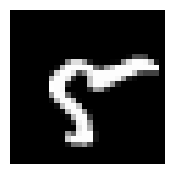

Label: 5


In [89]:
# The image to be displayed and tested
i = 502


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 0s 22ms/step


<BarContainer object of 10 artists>

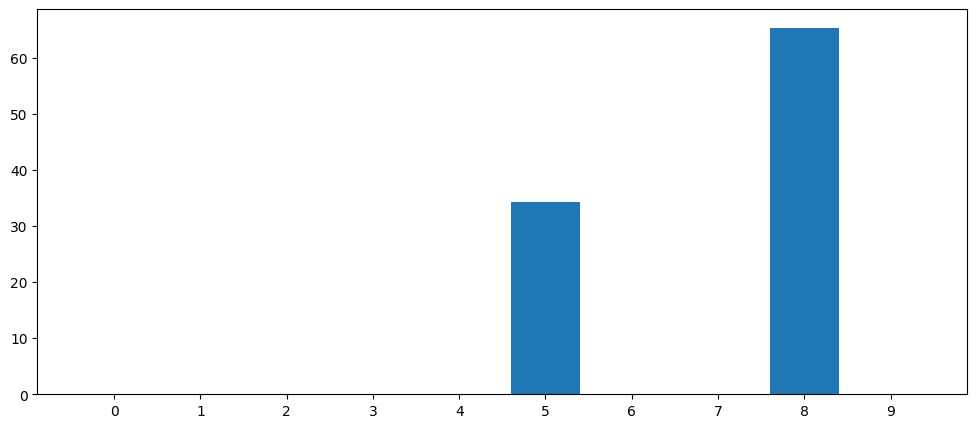

In [90]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])

## Visualizing in Tensorboard

In [91]:
os.environ['TENSORBOARD_BINARY'] = '/home/user01/miniconda3/envs/lab/bin/tensorboard'

%load_ext tensorboard
%tensorboard --logdir 'logs/fit/'


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31912), started 0:07:49 ago. (Use '!kill 31912' to kill it.)